# Linear Support Vector Machine SVM on Wine

Let's predict wine!

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
datasource = "datasets/winequality-red.csv"

In [5]:
print(os.path.exists(datasource))

True


In [26]:
dataset = pd.read_csv(datasource).sample(frac = 1).reset_index(drop = True)
del dataset["Unnamed: 0"]

In [27]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,10.6,1.025,0.43,2.8,0.080,21.0,84.0,0.99850,3.06,0.57,10.1,5
1,11.9,0.580,0.66,2.5,0.072,6.0,37.0,0.99920,3.05,0.56,10.0,5
2,8.5,0.460,0.59,1.4,0.414,16.0,45.0,0.99702,3.03,1.34,9.2,5
3,13.3,0.430,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,5
4,7.8,0.340,0.37,2.0,0.082,24.0,58.0,0.99640,3.34,0.59,9.4,6


In [28]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [41]:
selected_features = [1, 6, 9, 10]

# volatile acidity
# total sulfur dioxide
# sulphates
# alcohol

In [44]:
feature_names = [dataset.columns[i].replace("\x20", "_") 
                     for i in selected_features]

print(feature_names)

['volatile_acidity', 'total_sulfur_dioxide', 'sulphates', 'alcohol']


In [30]:
X = scale(np.array(dataset.iloc[:, selected_features]))

In [31]:
X.shape

(1599, 4)

In [32]:
y = np.array(dataset["quality"])

In [33]:
y.shape

(1599,)

## Binarize y

In [34]:
print("Before Binarization", 
        {i: np.sum(y == i) for i in np.unique(y)})

Before Binarization {3: 10, 4: 53, 5: 681, 6: 638, 7: 199, 8: 18}


In [35]:
y = y >= 6

print("After Binarization", 
         {i: np.sum(y == i) for i in np.unique(y)})

After Binarization {False: 744, True: 855}


## Split data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [37]:
X_train.shape

(1199, 4)

In [38]:
X_test.shape

(400, 4)

In [39]:
y_train.shape

(1199,)

In [40]:
y_test.shape

(400,)

## Create linear SVM model

In [56]:
feature_columns = [tf.contrib.layers.real_valued_column(feature_name)
                      for feature_name in feature_names]

In [57]:
print(feature_columns)

[_RealValuedColumn(column_name='volatile_acidity', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='total_sulfur_dioxide', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='sulphates', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='alcohol', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)]


In [58]:
classifier = tf.contrib.learn.SVM("example_id", 
                                    feature_columns = feature_columns, 
                                     l2_regularization = 1.0)

## Train and prepare

In [59]:
for i, feature_name in enumerate(feature_names):
    print(i, feature_name)

0 volatile_acidity
1 total_sulfur_dioxide
2 sulphates
3 alcohol


In [60]:
def input_fn():
    columns = {
        feature_name: tf.constant(np.expand_dims(X_train[:, i], 1))
            for i, feature_name in enumerate(feature_names)
    }
    
    columns["example_id"] = tf.constant([str(i + 1) for i in range(len(X_train))])
    
    labels = tf.constant(y_train)
    
    return columns, labels
    

Train the SVM

In [61]:
classifier.fit(input_fn = input_fn, steps = 30)

SVM(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinarySvmHead object at 0x000001811FF0A320>, 'feature_columns': [_RealValuedColumn(column_name='volatile_acidity', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='total_sulfur_dioxide', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='sulphates', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='alcohol', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)], 'optimizer': <tensorflow.contrib.linear_optimizer.python.sdca_optimizer.SDCAOptimizer object at 0x000001811FF0A198>, 'weight_column_name': None, 'update_weights_hook': <tensorflow.contrib.learn.python.learn.estimators.linear._SdcaUpdateWeightsHook object at 0x000001811FF0A2E8>})

## Evaluation

We'll create a predict_fn() to supply data for predictions. Then we'll call classifier.predict() to create y_pred

In [62]:
def predict_fn():
    columns = {
        feature_name: tf.constant(np.expand_dims(X_test[:, i], 1))
            for i, feature_name in enumerate(feature_names)
    }
    
    columns["example_id"] = tf.constant([str(i + 1) for i in range(len(X_test))])
    return columns

In [66]:
y_pred = classifier.predict(input_fn = predict_fn)
y_pred = list(map(lambda i: i["classes"], y_pred))
print(y_pred)

[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 

## Confusion matrix and evaluation

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [68]:
print("Accuracy", accuracy_score(y_test, y_pred))

Accuracy 0.755


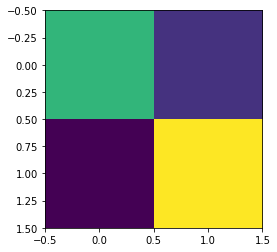

In [69]:
plt.imshow(confusion_matrix(y_test, y_pred))